# Execute Quantum Dynamics with PyTDSCF --Taylor expansion PES

In [1]:
try:
    import pytdscf
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/PyTDSCF --quiet
try:
    import discvar
except ModuleNotFoundError:
    !uv pip install -U git+https://github.com/QCLovers/Discvar --quiet

In [2]:
import itertools
from collections import defaultdict
from math import factorial, sqrt

import numpy as np
import sympy
from discvar import HarmonicOscillator as HO
from pytdscf import BasInfo, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian
from pytdscf.potentials.ch2o_potential import k_orig

import pympo

In [3]:
backend = "jax"
m = 30
N = 9
Δt = 0.1
cutoff = 0.0  # 1.e-09

$$
V - V_0 = \frac{k_{11}}{2!} Q_1^2 + \frac{k_{22}}{2!} Q_2^2 + \frac{k_{33}}{2!} Q_3^2 + \frac{k_{111}}{3!} Q_1^3 + \frac{k_{122}}{2!} Q_1Q_2^2 + \cdots
$$

In [4]:
print(f"{len(k_orig)=}")
active_modes = sorted(list(set(itertools.chain.from_iterable(k_orig.keys()))))
index = {}
for i, mode in enumerate(active_modes):
    index[mode] = i
print(f"{index=}")
f = len(active_modes)
k_new = {}
for key, value in k_orig.items():
    new_key = tuple([index[k] for k in key])
    if abs(value) > cutoff:
        k_new[new_key] = value
print(f"{len(k_new)=}")

len(k_orig)=114
index={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
len(k_new)=114


In [5]:
k_new

{(0, 0): 2.881141028397287e-05,
 (1, 1): 3.2448494255464496e-05,
 (2, 2): 4.725466264016419e-05,
 (3, 3): 6.805132227202656e-05,
 (4, 4): 0.00017348287106252062,
 (5, 5): 0.0001808886981537931,
 (2, 2, 2): -1.1756574314828089e-07,
 (3, 3, 3): 1.956730822300732e-06,
 (4, 4, 4): 9.330094468538158e-06,
 (5, 5, 5): -9.893510625593033e-09,
 (0, 0, 2): -1.238616135463855e-07,
 (1, 1, 2): 2.3333266618281752e-07,
 (0, 3, 3): 7.709229058903663e-10,
 (0, 0, 3): 6.899760007718777e-08,
 (1, 1, 3): 4.7154784410294076e-08,
 (2, 3, 3): 3.410048987055054e-07,
 (2, 2, 3): 2.858839109343442e-07,
 (0, 4, 4): 2.955204472579738e-09,
 (0, 0, 4): -9.109739004604497e-07,
 (1, 1, 4): -6.881771806581336e-07,
 (2, 4, 4): -7.439406041842036e-08,
 (2, 2, 4): -3.3560843836427284e-07,
 (3, 4, 4): -9.31531844617526e-08,
 (3, 3, 4): -2.9128037127557674e-07,
 (0, 5, 5): 3.2121787745431932e-09,
 (2, 5, 5): 6.435921392674742e-07,
 (3, 5, 5): -6.933166666974028e-07,
 (4, 5, 5): 1.0040242952014167e-05,
 (4, 4, 5): 3.469153

In [6]:
freqs = [
    sqrt(k_new[(k, k)]) * units.au_in_cm1 for k in range(f)
]  # a.u. (sqrt{omega^2} = omega)
freqs  # in cm^{-1}

[1178.0577664330528,
 1250.20606814231,
 1508.7131015744023,
 1810.5170221732483,
 2890.763940664299,
 2951.821181690477]

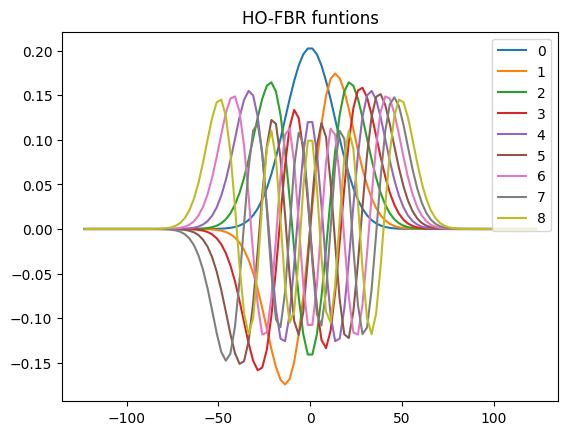

In [7]:
nprims = [N] * f  # Number of primitive basis
dvr_prims = [
    # HO(ngrid=nprim, omega=omega, units='cm-1')
    HO(nprim, omega)
    for nprim, omega in zip(nprims, freqs, strict=True)
]
dvr_prims_redundant = [
    # HO(ngrid=nprim, omega=omega, units='cm-1')
    HO(nprim+4, omega)
    for nprim, omega in zip(nprims, freqs, strict=True)
]
ndof = len(dvr_prims)  # Number of degree of freedom
basinfo = BasInfo([dvr_prims], spf_info=None)  # Set basis information object

dvr_prims[0].plot_fbr()

In [8]:
dq2 = [prim.get_2nd_derivative_matrix_fbr() for prim in dvr_prims]
q_scale = 10
q1 = [prim.get_pos_rep_matrix() / q_scale for prim in dvr_prims_redundant]
q2 = [ints @ ints for ints in q1]
q3 = [ints @ ints @ ints for ints in q1]
q4 = [ints @ ints @ ints @ ints for ints in q1]
qn = [[ints[:N, :N] for ints in q] for q in [q1, q2, q3, q4]]

In [9]:
kinetic_sop = pympo.SumOfProducts([])
for isite in range(f):
    kinetic_sop -= (
        1
        / 2
        * pympo.OpSite(
            r"\frac{\partial}{\partial q^2_{" + f"{isite}" + r"}}",
            isite,
            value=dq2[isite],
        )
    )
kinetic_sop.symbol

-0.5*\frac{\partial}{\partial q^2_{0}} - 0.5*\frac{\partial}{\partial q^2_{1}} - 0.5*\frac{\partial}{\partial q^2_{2}} - 0.5*\frac{\partial}{\partial q^2_{3}} - 0.5*\frac{\partial}{\partial q^2_{4}} - 0.5*\frac{\partial}{\partial q^2_{5}}

In [10]:
potential_sop = pympo.SumOfProducts([])
coef_symbol = {}
for key, coef in k_new.items():
    cnt_site = defaultdict(int)
    for isite in key:
        cnt_site[isite] += 1
    op = 1
    coef_sym = sympy.Symbol(f"k_{key}")
    for isite, order in cnt_site.items():
        coef /= factorial(order)
        op *= pympo.OpSite(
            f"q^{order}" + r"_{" + f"{isite}" + r"}",
            isite,
            value=qn[order - 1][isite],
        )
    op *= coef_sym
    coef_symbol[coef_sym] = coef * (q_scale ** len(key))
    potential_sop += op
potential_sop.symbol

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

In [11]:
coef_symbol

{k_(0, 0): 0.0014405705141986437,
 k_(1, 1): 0.001622424712773225,
 k_(2, 2): 0.002362733132008209,
 k_(3, 3): 0.003402566113601328,
 k_(4, 4): 0.008674143553126032,
 k_(5, 5): 0.009044434907689655,
 k_(2, 2, 2): -1.959429052471348e-05,
 k_(3, 3, 3): 0.00032612180371678867,
 k_(4, 4, 4): 0.0015550157447563595,
 k_(5, 5, 5): -1.6489184375988388e-06,
 k_(0, 0, 2): -6.193080677319275e-05,
 k_(1, 1, 2): 0.00011666633309140877,
 k_(0, 3, 3): 3.8546145294518314e-07,
 k_(0, 0, 3): 3.4498800038593886e-05,
 k_(1, 1, 3): 2.3577392205147037e-05,
 k_(2, 3, 3): 0.0001705024493527527,
 k_(2, 2, 3): 0.0001429419554671721,
 k_(0, 4, 4): 1.477602236289869e-06,
 k_(0, 0, 4): -0.00045548695023022486,
 k_(1, 1, 4): -0.0003440885903290668,
 k_(2, 4, 4): -3.719703020921018e-05,
 k_(2, 2, 4): -0.0001678042191821364,
 k_(3, 4, 4): -4.65765922308763e-05,
 k_(3, 3, 4): -0.00014564018563778837,
 k_(0, 5, 5): 1.6060893872715966e-06,
 k_(2, 5, 5): 0.0003217960696337371,
 k_(3, 5, 5): -0.0003466583333487014,
 k_(4,

In [12]:
hamiltonian_sop = pympo.SumOfProducts([])
hamiltonian_sop += kinetic_sop
hamiltonian_sop += potential_sop
hamiltonian_sop = hamiltonian_sop.simplify()
hamiltonian_sop.symbol

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

2024-12-31 13:57:36.122 | INFO     | pympo.bipartite:assign:282 - assigned 1/6
2024-12-31 13:57:36.130 | INFO     | pympo.bipartite:assign:282 - assigned 2/6
2024-12-31 13:57:36.137 | INFO     | pympo.bipartite:assign:282 - assigned 3/6
2024-12-31 13:57:36.142 | INFO     | pympo.bipartite:assign:282 - assigned 4/6
2024-12-31 13:57:36.145 | INFO     | pympo.bipartite:assign:282 - assigned 5/6
2024-12-31 13:57:36.147 | INFO     | pympo.bipartite:assign:282 - assigned 6/6


CPU times: user 60 μs, sys: 3 μs, total: 63 μs
Wall time: 62.9 μs
CPU times: user 36.2 ms, sys: 1.36 ms, total: 37.6 ms
Wall time: 37 ms


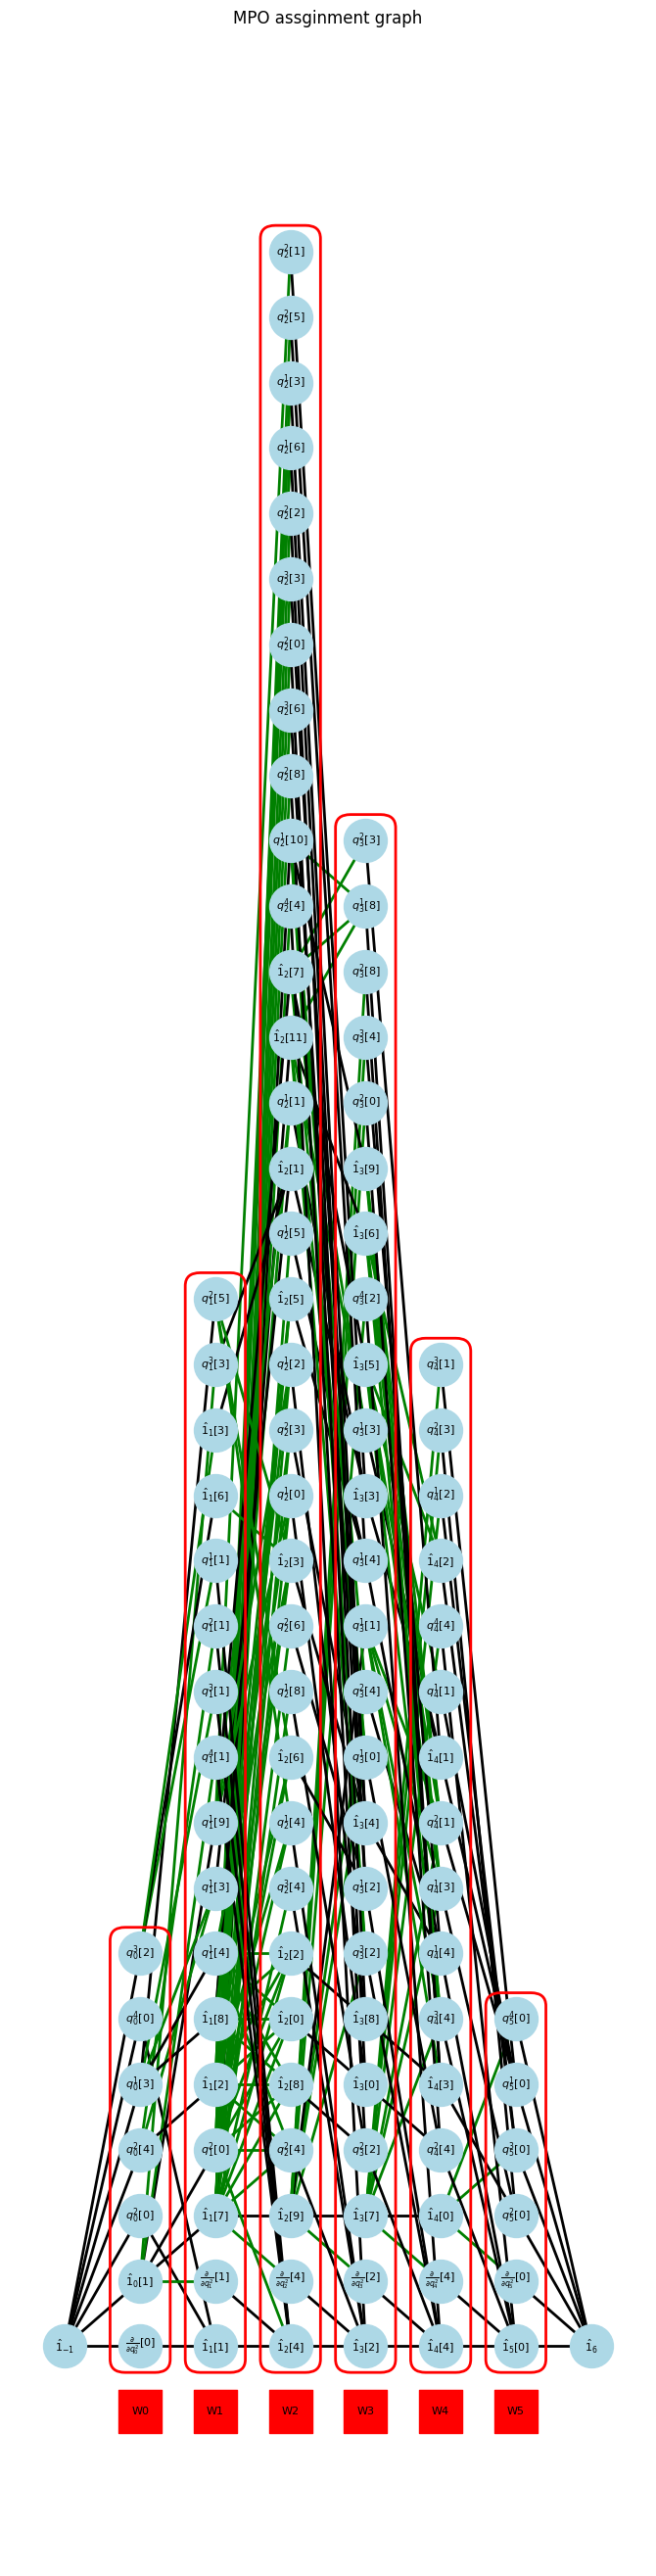

Matrix([[k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} - 0.5*\frac{\partial}{\partial q^2_{0}}, 1, q^3_{0}, q^1_{0}, q^2_{0}]])

Matrix([
[      0,                                                              1, 0,                      0,       0,       0, 0, 0, 0,       0],
[q^2_{1}, k_(1, 1, 1, 1)*q^4_{1} - 0.5*\frac{\partial}{\partial q^2_{1}}, 0, k_(1, 1, 1, 5)*q^3_{1},       0,       0, 0, 1, 0, q^1_{1}],
[      0,                                         k_(0, 0, 0, 1)*q^1_{1}, 0,         k_(0, 0, 0, 5),       0,       0, 1, 0, 0,       0],
[      0,                                         k_(0, 1, 1, 1)*q^3_{1}, 0,    k_(0, 1, 5)*q^1_{1}, q^1_{1}, q^2_{1}, 0, 0, 1,       0],
[      0,                                         k_(0, 0, 1, 1)*q^2_{1}, 1, k_(0, 0, 1, 5)*q^1_{1},       0,       0, 0, 0, 0,       0]])

Matrix([
[                                         k_(1, 1, 4, 4),                                            0,                                          k_(1, 1, 5, 5),         k_(1, 1, 2, 4)*q^1_{2} + k_(1, 1, 4),                                                 k_(1, 1) + k_(1, 1, 2)*q^1_{2} + k_(1, 1, 2, 2)*q^2_{2},                               k_(1, 1, 3, 4),         k_(1, 1, 2, 3)*q^1_{2} + k_(1, 1, 3), 0,                                          k_(1, 1, 3, 3), 0,       0, 0],
[                                                      0,                                            0,                                                       0,                                            0,                                                                                                       1,                                            0,                                            0, 0,                                                       0, 0,       0, 0],
[                              

Matrix([
[                                           1,       0,                                                                                    0,                                            0,                                            0, 0, 0, 0,                      0, 0],
[                                           0,       0,                                                                                    0,                                            1,                                            0, 0, 0, 0,                      0, 0],
[                                           0,       0,                                                                                    0,                                            0,                                            0, 0, 0, 0,                      1, 0],
[                                           0,       0,                                                                                    0,                                     

Matrix([
[0,                                            0,                      0,                                            0,                                                                              q^2_{4}],
[0,                       k_(3, 4, 4, 5)*q^2_{4},                      0,         k_(3, 4, 5, 5)*q^1_{4} + k_(3, 5, 5),                                                               k_(3, 4, 4, 4)*q^3_{4}],
[0,                                            0,                      0,                                            0,                                                                                    1],
[0,                                            1,                      0,                                            0,                                                                                    0],
[0,                                            0,                      0,                                            0,                                            

Matrix([
[k_(5, 5, 5)*q^3_{5} + k_(5, 5, 5, 5)*q^4_{5} - 0.5*\frac{\partial}{\partial q^2_{5}}],
[                                                                             q^1_{5}],
[                                                                             q^3_{5}],
[                                                                             q^2_{5}],
[                                                                                   1]])

In [13]:
%time am_hamiltonian = pympo.AssignManager(hamiltonian_sop)
%time am_hamiltonian.assign(keep_symbol=False)  # This part takes time due to using Sympy
am_hamiltonian.show_graph()
display(*am_hamiltonian.Wsym)
# %time potential_mpo = am_potential.numerical_mpo()
hamiltonian_mpo = am_hamiltonian.numerical_mpo(subs=coef_symbol)

In [14]:
display(*sympy.Mul(*am_hamiltonian.Wsym).expand())
display(hamiltonian_sop.symbol.expand())

assert sympy.Mul(*am_hamiltonian.Wsym)[0].expand() == hamiltonian_sop.symbol, (
    sympy.Mul(*am_hamiltonian.Wsym)[0].expand() - hamiltonian_sop.symbol
)

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

k_(0, 0)*q^2_{0} + k_(0, 0, 0, 0)*q^4_{0} + k_(0, 0, 0, 1)*q^3_{0}*q^1_{1} + k_(0, 0, 0, 4)*q^3_{0}*q^1_{4} + k_(0, 0, 0, 5)*q^3_{0}*q^1_{5} + k_(0, 0, 1, 1)*q^2_{0}*q^2_{1} + k_(0, 0, 1, 5)*q^2_{0}*q^1_{1}*q^1_{5} + k_(0, 0, 2)*q^2_{0}*q^1_{2} + k_(0, 0, 2, 2)*q^2_{0}*q^2_{2} + k_(0, 0, 2, 3)*q^2_{0}*q^1_{2}*q^1_{3} + k_(0, 0, 2, 4)*q^2_{0}*q^1_{2}*q^1_{4} + k_(0, 0, 3)*q^2_{0}*q^1_{3} + k_(0, 0, 3, 3)*q^2_{0}*q^2_{3} + k_(0, 0, 3, 4)*q^2_{0}*q^1_{3}*q^1_{4} + k_(0, 0, 4)*q^2_{0}*q^1_{4} + k_(0, 0, 4, 4)*q^2_{0}*q^2_{4} + k_(0, 0, 5, 5)*q^2_{0}*q^2_{5} + k_(0, 1, 1, 1)*q^1_{0}*q^3_{1} + k_(0, 1, 1, 2)*q^1_{0}*q^2_{1}*q^1_{2} + k_(0, 1, 1, 3)*q^1_{0}*q^2_{1}*q^1_{3} + k_(0, 1, 1, 4)*q^1_{0}*q^2_{1}*q^1_{4} + k_(0, 1, 2, 2)*q^1_{0}*q^1_{1}*q^2_{2} + k_(0, 1, 3, 3)*q^1_{0}*q^1_{1}*q^2_{3} + k_(0, 1, 4)*q^1_{0}*q^1_{1}*q^1_{4} + k_(0, 1, 4, 4)*q^1_{0}*q^1_{1}*q^2_{4} + k_(0, 1, 5)*q^1_{0}*q^1_{1}*q^1_{5} + k_(0, 1, 5, 5)*q^1_{0}*q^1_{1}*q^2_{5} + k_(0, 2, 2, 4)*q^1_{0}*q^2_{2}*q^1_{4} + k

In [15]:
H = {
    tuple([(idof, idof) for idof in range(f)]): TensorOperator(mpo=hamiltonian_mpo)
}
hamiltonian = [[H]]


H = TensorHamiltonian(f, potential=hamiltonian, kinetic=None, backend=backend) # because kinetic term is absorbed into potential
operators = {"hamiltonian": H}

In [16]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = m
model.init_HartreeProduct = [
    [
        [1.0] + [0.0] * (N-1) for _ in range(f)
    ]
]

In [17]:
jobname = "ch2o-mpo"
simulator = Simulator(jobname=jobname, model=model, backend=backend)
import time
start = time.time()
ener, wf = simulator.relax(savefile_ext="_gs", maxstep=10, stepsize=0.1)#.(maxstep=100, stepsize=Δt)
end = time.time()
print(end-start)
ener * units.au_in_eV

2024-12-31 13:57:37,127 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-12-31 13:57:37,127 - INFO:main.pytdscf._const_cls - Log file is ./ch2o-mpo_relax/main.log
2024-12-31 13:57:37,127 - INFO:main.pytdscf.simulator_cls - Set integral of DVR basis
2024-12-31 13:57:37,131 - INFO:main.pytdscf.simulator_cls - Set initial wave function (DVR basis)
2024-12-31 13:57:37,131 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-12-31 13:57:37,131 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2024-12-31 13:57:37,604 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_ch2o-mpo_gs.pkl
2024-12-31 13:57:37,604 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs]
2024-12-31 13:57:39,61

3.726288080215454


0.7088296546418331

In [18]:
!tail ch2o-mpo_relax/main.log

/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.400 | elapsed[sec]:     1.90 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.500 | elapsed[sec]:     2.00 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.600 | elapsed[sec]:     2.09 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.700 | elapsed[sec]:     2.17 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.800 | elapsed[sec]:     2.26 
Saved wavefunction    0.900 [fs]
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.900 | elapsed[sec]:     2.34 
End     9 step; propagated    0.900 [fs]; AVG Krylov iteration: 3.00
End simulation and save wavefunction
Wave function is saved in wf_ch2o-mpo_gs.pkl


## Confirm with SOP model

In [19]:
from discvar import PrimBas_HO

prim_info = [
    [
        PrimBas_HO(0.0, omega, nprim)
        for nprim, omega in zip(nprims, freqs, strict=True)
    ]
]
nstate = len(
    prim_info
)  # len(prim_info) is number of state, in this case state is S0
ndof = len(prim_info[0])  # Number of degree of freedom, H2O has 3 DOFs
basinfo = BasInfo(prim_info, spf_info=None)  # Set basis information object
from pytdscf.hamiltonian_cls import read_potential_nMR

hamiltonian = read_potential_nMR(k_orig, cut_off=cutoff)
operators = {"hamiltonian": hamiltonian}

model = Model(basinfo, operators)
model.m_aux_max = m
model.init_HartreeProduct = [
    [
        [1.0] + [0.0] * (N-1) for _ in range(f)
    ]
]
jobname = "ch2o-sop"
simulator = Simulator(jobname, model, ci_type="MPS", backend="Numpy")

start = time.time()
ener, wf = simulator.relax(savefile_ext="_gs", maxstep=10, stepsize=0.1)
end = time.time()
print(end-start)
ener * units.au_in_eV

2024-12-31 13:57:41,124 - INFO:main.pytdscf.model_cls - The layer of SPF is not used.
2024-12-31 13:57:41,125 - INFO:main.pytdscf.hamiltonian_cls - Construct anharmonic polynomial operator
2024-12-31 13:57:41,127 - WARNING:main.pytdscf._const_cls - rebind const jobname
2024-12-31 13:57:41,129 - WARNING:main.pytdscf._const_cls - rebind const logger
2024-12-31 13:57:41,129 - WARNING:main.pytdscf._const_cls - rebind const logger
2024-12-31 13:57:41,130 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-12-31 13:57:41,130 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 

14.094701051712036


0.7088296546418337

In [20]:
!tail ch2o-sop_relax/main.log

| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.400 | elapsed[sec]:    11.37 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.500 | elapsed[sec]:    12.26 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.600 | elapsed[sec]:    13.11 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.700 | elapsed[sec]:    13.88 
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.800 | elapsed[sec]:    14.61 
Saved wavefunction    0.900 [fs]
| pop 1.0000 | ene[eV]:  0.7088297 | time[fs]:    0.900 | elapsed[sec]:    15.29 
End     9 step; propagated    0.900 [fs]; AVG Krylov iteration: 3.00
End simulation and save wavefunction
Wave function is saved in wf_ch2o-sop_gs.pkl
